In [63]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')
import pandas as pd, os, json, numpy as np, re, textacy, pickle, string, re, nltk,  spacy, flashtext, contractions, unicodedata
from datetime import datetime; from dateutil import parser; 
from collections import Counter; from pprint import pprint
import textacy; from textacy import preprocessing, ke, vsm, tm, text_utils, Corpus, doc
from cytoolz import itertoolz
import joblib; from tabulate import tabulate; from time import time
from flashtext import KeywordProcessor
from urllib.parse import urlparse

from gensim.models.wrappers import LdaMallet; from gensim.models import LdaModel, LsiModel,  HdpModel, CoherenceModel
import gensim; from gensim.corpora import Dictionary;  from gensim import corpora

import sklearn;from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation,  TruncatedSVD
from sklearn.model_selection import GridSearchCV
from pprint import pprint

from IPython.display import display
import seaborn as sns, matplotlib.pyplot as plt, matplotlib.image as mpimg, base64, io, os,  matplotlib.colors as mcolors
%matplotlib inline
sns.set()  # defines the style of the plots 
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches
from wordcloud import WordCloud, STOPWORDS

from sklearn.manifold import TSNE
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

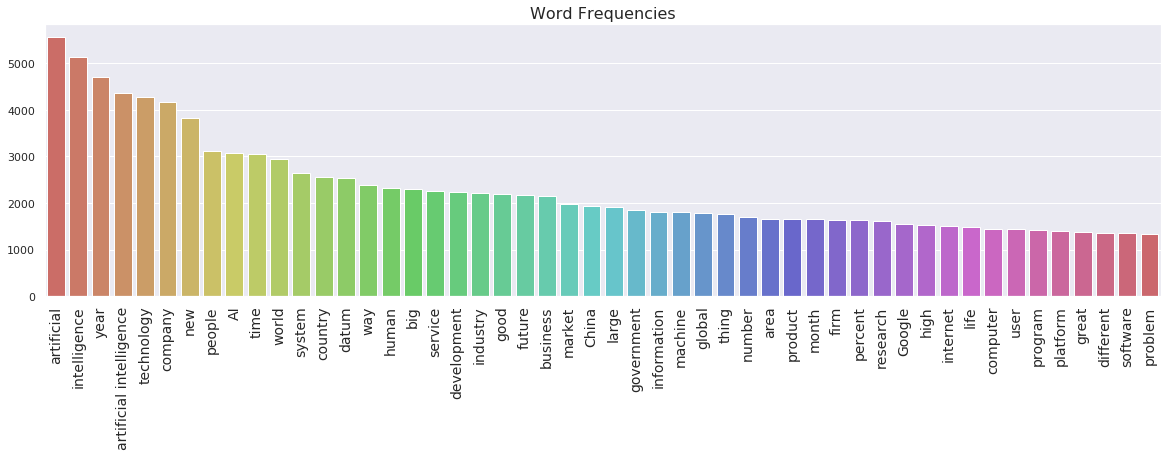

In [21]:
with open ('yak_vector', 'rb') as fp:# posrank terms
    terms = pickle.load(fp)#prnk yakws100 scak yak10 sr bot yak10

terms= [[i[0] for i in li] for li in terms]#for example prnk

############################this is for the tokenized sgr#############################################
terms_dict = Counter(np.concatenate(terms))#count words
terms_df = pd.DataFrame.from_dict(terms_dict, orient='index')#dict to dataframe
terms_df.rename(columns={0: 'count'}, inplace=True)#chnage the name of column
terms_df.sort_values('count', ascending=False, inplace=True)#sort

def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(terms_df)#changew raw
ax.set_title("Word Frequencies", fontsize=16);

# 1. This part cleans trims the dictionary from extreme values and looks again


In [23]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['people', 'subject', 'p.m.', 'early', 'time', 'year', 'use', 'not', 'would', 'say', 'could',  'be', 'know', 
                   'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see',
                   'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right',
                   'line', 'even', 'also', 'may', 'take', 'come' ,  'able',  'area','case',  'company','country',
                   'day','decade','example','future','head','high','January','lot','month','need','number','number',
                   'people','percent','place','result','thing','time','Tuesday','use','way','week',   'world','year',
                   'artificial intelligence', 'artificial intelligence AI', 'A.I.','ai' ,'April', 'August', 'century',
                   'date', 'December', 'difficult', 'dozen', 'February','form','great','history','hour','hundred',
                  'July','June','kilometer','kind','late','long','March','million','million','minute',
                   'November','October','part','past','point','previous', 'real','recent',
                   'role','September','term','thousand','today', 'January', 'May', 'Monday', 'Wednesday',
                  'Thursday', 'Friday', 'Saturday', 'Sunday', 'ush','ush(function', 'IST', 'ist' ])

from spacy.lang.en.stop_words import STOP_WORDS
stop_words =  set(stop_words).union(set(STOP_WORDS))

lms = [[word.lower() for word in doc if word not in stop_words] for doc in terms]     

abo=.95# for terms = .90, prnk. yak =.95 yak300 .95
belo=25# for tersm =25   yak =15, tr, prnk,sgrnk =10 yak 300 25
dictionary = Dictionary(documents=lms)
print("Found {} words.".format(len(dictionary.values())))
dictionary.filter_extremes(no_above=abo, no_below=belo)
dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

#dictionary.save('dictionary')
corpus = [dictionary.doc2bow(text) for text in lms]
#corpora.MmCorpus.serialize('corpus.mm', corpus)  # save corpus to disk
from gensim import matutils
data_dense =gensim.matutils.corpus2dense(corpus, len(dictionary.values()) )
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Found 355971 words.
Left with 5977 words.
Sparsicity:  1.835290539993037 %


parameter selection:  Adopting the uniform Dirichlet priors
suggested by Steyvers and Griffiths (2007) (alpha=50/T = 6.25; beta = 0.01 for 2 <= T <= 10),

The fixed unit of 120 words, originally preferred by Osgood et al. (1957)
in the early days of computer-assisted content analysis, may, however, still be found to
produce stable, interpretable representations of conceptual relationships at a

In [23]:
#hdp

hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
CoherenceModel(model=hdpmodel, texts=lms, dictionary=dictionary, coherence='c_v').get_coherence()

#to choose the opt number of topics check the weights set up a threshold (i.e 01)
def topic_prob_extractor(hdpmodel):
    shown_topics = hdpmodel.show_topics(num_topics=100, formatted=False)
    topics_nos = [x[0] for x in shown_topics ]
    weights = [ sum([item[1] for item in shown_topics[topicN][1]]) for topicN in topics_nos ]

    return pd.DataFrame({'topic_id' : topics_nos, 'weight' : weights})

topic_prob_extractor(hdpmodel)

0.5186364629784324

,topic_id,weight
0,0,0.061707
1,1,0.072227
2,2,0.066694
3,3,0.067741
4,4,0.035495
...,...,...
95,95,0.024431
96,96,0.022946
97,97,0.022285
98,98,0.021625


In [24]:
hdpmodel.show_topics(num_topics=60, formatted=False)[0:60]

[(0,
  [('artificial', 0.0064327009670871104),
   ('intelligence', 0.005929367033676389),
   ('new', 0.0050996533973030715),
   ('technology', 0.0049712752189310285),
   ('ai', 0.0030856671177520024),
   ('system', 0.003034934376167565),
   ('big', 0.002881444177642637),
   ('human', 0.0027308424194059187),
   ('industry', 0.0026198260807765213),
   ('development', 0.0025197527120956564),
   ('datum', 0.0024926230686345106),
   ('service', 0.0024433343614344597),
   ('business', 0.0023854686115915404),
   ('large', 0.002267874967353681),
   ('china', 0.0022367382365535544),
   ('research', 0.002190305870339504),
   ('market', 0.0021409761617293198),
   ('global', 0.0021080394122514334),
   ('government', 0.0021000316867383737),
   ('information', 0.002036497559516992)]),
 (1,
  [('artificial', 0.007216380544164239),
   ('intelligence', 0.006596335274659095),
   ('technology', 0.005936652409608274),
   ('new', 0.005262017020338),
   ('ai', 0.0041197708711050674),
   ('datum', 0.00353520

# Select the best model

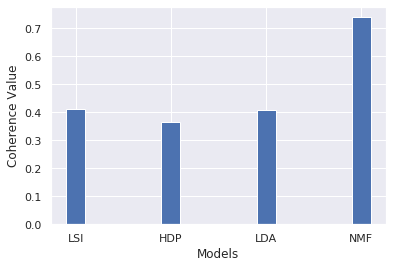

In [26]:
ntl=100
lsimodel = LsiModel(corpus=corpus, num_topics=ntl, id2word=dictionary)
ldamodel = LsiModel(corpus=corpus, num_topics=ntl, id2word=dictionary)
#mallet = LdaMallet(mallet_path, id2word=dictionary, num_topics=ntl, corpus=corpus)
#LDMallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet)
##########NMF############################
vectorizer = vsm.Vectorizer(tf_type="linear", apply_idf=True, idf_type="smooth", norm="l2",\
                                min_df=belo, max_df=abo)#tfidf
doc_term_matrix =vectorizer.fit_transform(lms)

nmfmodel = NMF( init="nndsvd", n_components=ntl ) 
doc_topic_matrix = nmfmodel.fit_transform( doc_term_matrix )#
H = nmfmodel.components_ # term weights relative to each of the k topics.
#to which topic is related the word
terms=vectorizer.terms_list
#############################################

lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]
#maltopics = [[word for word, prob in topic] for topicid, topic in LDMallet.show_topics(num_topics=ntl, formatted=False)]
#######GET TOPICS with KWs for NMF######################################

def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

nmftopics = []#descriptors is the other name
for topic_index in range(ntl):#10 is the no of topic words, as with the other models=10
    nmftopics.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( nmftopics[topic_index] )
 ##########################################################################   

lsi_coherence = CoherenceModel(topics=lsitopics, texts=lms, dictionary=dictionary, window_size=200).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics, texts=lms, dictionary=dictionary, window_size=200).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=lms, dictionary=dictionary, window_size=200).get_coherence()
#mallet_coherence = CoherenceModel(topics=maltopics, texts=lms, dictionary=dictionary, window_size=200).get_coherence()
nmf_coherence = CoherenceModel(topics=nmftopics, texts=lms, dictionary=dictionary, window_size=200).get_coherence()

def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, nmf_coherence],
                   ['LSI', 'HDP', 'LDA', 'NMF'])

# Gensim Models

In [27]:
########################GENSIM MODELS#############################
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = LdaMallet(mallet_path, id2word=dictionary, corpus=corpus, num_topics=num_topics)
        #HdpModel(corpus=corpus, id2word=dictionary)
        #LdaMallet(mallet_path, id2word=dictionary, corpus=corpus,iterations=30 , num_topics=num_topics)
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        #LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        topics = [[word for word, prob in topic] for topicid, topic in model.show_topics(num_topics=num_topics, formatted=False)]
        coherencemodel = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v',window_size=200)
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

lmt=100; strt=10; stp=10

model_list, coherence_values = compute_coherence_values(dictionary, corpus=corpus, texts=lms, start=strt, limit=lmt, step=stp)

Show Graph

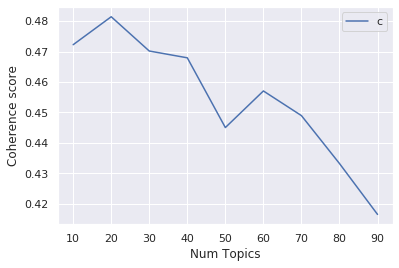

In [33]:
x = range(strt, lmt, stp)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show();

.55 is okay

.65 might be as good as it is going to get

.7 is nice


# Select the model and print the topics

In [34]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10,num_topics=40))

[(0,
  '0.010*"artificial" + 0.010*"facebook" + 0.010*"intelligence" + '
  '0.007*"technology" + 0.007*"user" + 0.007*"network" + 0.006*"ai" + '
  '0.006*"social network" + 0.006*"social" + 0.006*"post"'),
 (1,
  '0.007*"father" + 0.007*"artificial" + 0.006*"intelligence" + 0.006*"life" + '
  '0.005*"young" + 0.005*"work" + 0.005*"british" + 0.004*"science" + '
  '0.004*"star" + 0.004*"britain"'),
 (2,
  '0.018*"turkey" + 0.008*"saudi" + 0.008*"istanbul" + 0.007*"arabia" + '
  '0.007*"saudi arabia" + 0.006*"intelligence" + 0.006*"artificial" + '
  '0.006*"germany" + 0.006*"international" + 0.005*"european"'),
 (3,
  '0.009*"cyber attack" + 0.006*"attack" + 0.006*"artificial" + '
  '0.005*"technology" + 0.005*"mustafa" + 0.005*"intelligence" + '
  '0.005*"machine" + 0.005*"new" + 0.005*"cyber" + 0.004*"threat"'),
 (4,
  '0.010*"intelligence" + 0.009*"artificial" + 0.008*"business" + '
  '0.007*"technology" + 0.007*"new" + 0.007*"service" + 0.006*"ai" + '
  '0.006*"firm" + 0.005*"datum" 

**LDA parameters :**
Assuming symmetric Dirichlet distributions, a low alpha value places more weight on having each document composed of only a few dominant topics (whereas a high value will return many more relatively dominant topics). Similarly, a low beta value places more weight on having each topic composed of only a few dominant words.
Also, an asymmetric alpha is helpful, where as an asymmetric beta is largely not.
Gensim: ’asymmetric’: Uses a fixed normalized asymmetric prior of 1.0 / topicno.
’auto’: Learns an asymmetric prior from the corpus, or you can 1D array of length equal to the number of expected topics that expresses our a-priori belief for the each topics’ probability. 

In [35]:
ntp=60
LDModel = LdaModel(corpus=corpus, num_topics=ntp, id2word=dictionary)
#mallet = LdaMallet(mallet_path, id2word=dictionary, num_topics=ntp, corpus=corpus)
#LDMallet = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet)

In [ ]:
#cm = CoherenceModel(model=LDMallet,topn=ntp, corpus=corpus, texts=lms, dictionary=dictionary, coherence='c_v',window_size=200)
#cm.get_coherence()  # get coherence value

In [227]:
#start HERE
#LDMallet.save('LDMallet')
#LDMallet =  LdaModel.load('LDMallet')

In [36]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    return terms

topic_kws= []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(ntp):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(LDModel,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_kws += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

income               0.013
job                  0.008
yen                  0.008
utilization          0.008
labor                0.007
bank                 0.007
welfare              0.007
worker               0.006
unemployment         0.006
tax                  0.006


<function print>

Topic 1 |---------------------

technology           0.008
artificial           0.008
new                  0.008
intelligence         0.007
google               0.006
ai                   0.006
developer            0.005
system               0.005
software             0.005
datum                0.004


<function print>

Topic 2 |---------------------

disk                 0.009
business             0.007
artificial           0.006
industry             0.006
intelligence         0.006
technology           0.006
market               0.006
global               0.006
financial            0.005
datum                0.005


<function print>

Topic 3 |---------------------

southeastern         0.007
artificial           0.007
intelligence         0.006
facebook inc.        0.005
google               0.004
new                  0.004
technology           0.004
ai                   0.004
tesla ceo            0.004
machine              0.003


<function print>

Topic 4 |---------------------

amazon web services  0.007
amazon web           0.006
amazon               0.006
web services         0.006
artificial           0.006
datum                0.006
intelligence         0.005
stay                 0.005
customer             0.005
web                  0.005


<function print>

Topic 5 |---------------------

financial group      0.011
artificial           0.009
intelligence         0.008
new                  0.007
listening            0.006
excellence           0.006
technology           0.005
user                 0.005
spanish              0.005
new device           0.005


<function print>

Topic 6 |---------------------

information          0.006
artificial           0.006
security             0.006
new                  0.005
intelligence         0.004
system               0.004
technology           0.004
datum                0.004
government           0.004
police               0.004


<function print>

Topic 7 |---------------------

technology           0.008
artificial           0.008
business             0.007
r&d center           0.007
solutions            0.007
pm                   0.007
intelligence         0.007
r&d                  0.006
member state         0.006
new                  0.005


<function print>

Topic 8 |---------------------

artificial           0.007
technology           0.007
industry             0.006
intelligence         0.006
sector               0.006
development          0.006
economic             0.006
government           0.006
new                  0.006
economy              0.005


<function print>

Topic 9 |---------------------

artificial           0.011
intelligence         0.011
technology           0.010
ai                   0.010
service              0.006
business             0.006
datum                0.006
system               0.006
japanese company     0.006
function             0.006


<function print>

Topic 10 |---------------------

artificial           0.007
intelligence         0.006
image                0.006
new                  0.006
facebook             0.005
video                0.005
user                 0.005
feature              0.004
news                 0.004
network              0.004


<function print>

Topic 11 |---------------------

artificial           0.007
new                  0.006
authentication       0.006
intelligence         0.006
jung                 0.005
year                 0.005
technology           0.005
datum                0.004
ai voice             0.004
sandwich             0.004


<function print>

Topic 12 |---------------------

japanese             0.008
winter               0.007
rice                 0.007
olympics             0.006
new                  0.006
food                 0.006
chef                 0.006
story                0.005
french               0.005
artificial           0.005


<function print>

Topic 13 |---------------------

thing iot            0.019
artificial           0.010
intelligence         0.009
sophia               0.008
robot                0.008
technology           0.007
humanoid             0.007
ai                   0.007
hong                 0.006
humanoid robot       0.006


<function print>

Topic 14 |---------------------

managing director    0.025
kakao                0.023
messenger            0.023
managing             0.020
messaging            0.013
assistant            0.010
operator             0.010
language             0.010
service              0.009
actionable           0.009


<function print>

Topic 15 |---------------------

kilogram             0.009
artificial           0.009
intelligence         0.008
pm                   0.008
bixby                0.007
prominence           0.007
smartphone           0.007
new                  0.006
samsung              0.006
technology           0.005


<function print>

Topic 16 |---------------------

dessert              0.033
communication technology 0.032
championship         0.008
smart factory        0.007
shop                 0.007
tea                  0.007
new zealand          0.006
cookie               0.006
artificial           0.006
zealand              0.005


<function print>

Topic 17 |---------------------

artificial           0.010
intelligence         0.009
technology           0.008
ai                   0.007
machine              0.007
system               0.006
human                0.006
new                  0.006
learning             0.005
development          0.004


<function print>

Topic 18 |---------------------

artificial           0.008
mark zuckerberg      0.007
facebook             0.007
technology           0.007
intelligence         0.007
zuckerberg           0.006
facebook ceo         0.006
social               0.006
new                  0.006
user                 0.006


<function print>

Topic 19 |---------------------

artificial           0.007
new                  0.006
intelligence         0.005
university           0.005
life                 0.005
study                0.004
sweet                0.004
technology           0.004
human                0.004
mars                 0.004


<function print>

Topic 20 |---------------------

twitter user         0.026
energy company       0.018
nikkei               0.014
brent                0.013
oil price            0.011
barrel               0.008
carolina             0.006
artificial           0.005
crude                0.005
composite            0.005


<function print>

Topic 21 |---------------------

technology           0.008
intelligence         0.008
artificial           0.008
ai                   0.006
new                  0.005
human                0.005
drone                0.004
computer             0.004
effectiveness        0.004
researcher           0.004


<function print>

Topic 22 |---------------------

tumblr               0.011
european             0.007
brussels             0.006
intelligence         0.006
european commission  0.006
new                  0.005
european parliament  0.005
artificial           0.005
whatsapp             0.005
eu                   0.004


<function print>

Topic 23 |---------------------

twitter              0.007
facebook             0.007
artificial           0.006
trump                0.006
merkel               0.006
election             0.006
political            0.006
intelligence         0.006
medium               0.006
news                 0.006


<function print>

Topic 24 |---------------------

artificial           0.011
intelligence         0.010
technology           0.006
industrial           0.006
fourth               0.006
new                  0.005
business             0.005
development          0.005
government           0.005
revolution           0.005


<function print>

Topic 25 |---------------------

potato               0.054
utmost               0.019
roll                 0.008
brave                0.008
fossil               0.007
intelligence         0.005
new                  0.004
wall street journal  0.004
artificial           0.004
street journal       0.004


<function print>

Topic 26 |---------------------

stock                0.012
profit               0.009
market               0.008
u.s.                 0.007
share                0.007
price                0.007
stock market         0.007
new                  0.007
artificial           0.007
intelligence         0.007


<function print>

Topic 27 |---------------------

artificial           0.009
intelligence         0.008
human                0.007
musk                 0.006
technology           0.006
new                  0.005
elon musk            0.005
ai                   0.005
elon                 0.005
tesla                0.005


<function print>

Topic 28 |---------------------

digitalization       0.022
elementary           0.009
intelligence         0.008
ltd.                 0.008
technology           0.008
artificial           0.008
energy efficiency    0.007
european country     0.006
nov                  0.005
seoul national university 0.005


<function print>

Topic 29 |---------------------

yen                  0.010
new                  0.006
intelligence         0.006
artificial           0.005
parliament           0.005
member               0.005
minister             0.004
story                0.004
vote                 0.004
police               0.004


<function print>

Topic 30 |---------------------

mustafa              0.010
internet technology  0.009
intelligence         0.008
ai                   0.007
artificial           0.007
technology           0.007
terrorist            0.007
system               0.005
good example         0.005
robot                0.005


<function print>

Topic 31 |---------------------

taipei               0.037
central news agency  0.031
central news         0.009
blood                0.009
stomach              0.008
artificial           0.006
genetic              0.006
human                0.006
cell                 0.006
new                  0.005


<function print>

Topic 32 |---------------------

artificial           0.011
intelligence         0.009
ai                   0.009
device               0.009
technology           0.008
giant                0.008
mobile               0.008
new                  0.008
market               0.008
electronics          0.007


<function print>

Topic 33 |---------------------

central              0.007
turkey               0.007
government           0.007
deficit              0.006
osaka                0.005
central bank         0.005
population           0.005
health               0.005
municipality         0.005
rate                 0.004


<function print>

Topic 34 |---------------------

new                  0.007
artificial           0.006
intelligence         0.005
market               0.005
large                0.005
business             0.005
home                 0.004
industry             0.004
service              0.004
hotel                0.003


<function print>

Topic 35 |---------------------

sweet                0.008
artificial           0.007
love                 0.007
intelligence         0.007
doll                 0.006
human                0.006
new                  0.006
sex                  0.005
character            0.005
robot                0.005


<function print>

Topic 36 |---------------------

cloud                0.011
computing            0.010
technology           0.010
intelligence         0.010
internet             0.009
cloud computing      0.009
development          0.008
artificial           0.008
datum                0.008
iot                  0.008


<function print>

Topic 37 |---------------------

artificial           0.008
new                  0.006
human                0.006
scientist            0.006
intelligence         0.006
system               0.006
technology           0.005
university           0.005
earth                0.005
ai                   0.005


<function print>

Topic 38 |---------------------

intelligence         0.013
artificial           0.013
local                0.008
technology           0.008
sk                   0.008
bean                 0.007
north america        0.006
press conference     0.006
artificial intelligence technology 0.006
intelligence technology 0.006


<function print>

Topic 39 |---------------------

pr                   0.010
bean                 0.008
human                0.007
institute            0.006
radiation            0.006
mineral              0.006
intelligence         0.006
robot                0.006
cooking              0.005
artificial           0.005


<function print>

Topic 40 |---------------------

intelligence         0.008
artificial           0.007
system               0.006
human                0.005
technology           0.005
ai                   0.005
new                  0.004
machine              0.004
datum                0.004
large                0.004


<function print>

Topic 41 |---------------------

keyword              0.009
las vegas            0.007
cute                 0.006
flavor               0.006
treat                0.006
new                  0.006
consumer electronics 0.006
sputnik              0.005
greenhouse           0.005
drink                0.005


<function print>

Topic 42 |---------------------

keyword              0.009
intelligence         0.008
artificial           0.007
copyright            0.007
technology           0.005
new                  0.005
social               0.005
contact              0.005
ai                   0.004
business             0.004


<function print>

Topic 43 |---------------------

artificial           0.006
new                  0.006
school               0.006
intelligence         0.005
child                0.005
young                0.005
tokyo                0.004
work                 0.004
student              0.004
science              0.004


<function print>

Topic 44 |---------------------

convenience store    0.020
convenience          0.013
cream                0.011
dish                 0.011
store                0.009
japanese             0.009
menu                 0.009
source               0.008
restaurant           0.007
new                  0.007


<function print>

Topic 45 |---------------------

minister             0.008
intelligence         0.007
artificial           0.006
prime minister       0.006
technology           0.006
development          0.006
government           0.005
prime                0.005
new                  0.005
issue                0.004


<function print>

Topic 46 |---------------------

military             0.009
defense              0.008
aircraft             0.008
system               0.007
army                 0.007
artificial           0.007
mitsubishi           0.007
intelligence         0.006
technology           0.005
missile              0.005


<function print>

Topic 47 |---------------------

chicken              0.012
chocolate            0.011
tsai                 0.010
artificial           0.009
ml                   0.009
business_to_business 0.008
new                  0.008
technology           0.007
asian country        0.007
service company      0.007


<function print>

Topic 48 |---------------------

artificial           0.010
technology           0.009
datum                0.007
business             0.007
firm                 0.006
new                  0.006
intelligence         0.006
development          0.006
industry             0.006
sector               0.005


<function print>

Topic 49 |---------------------

game                 0.013
player               0.013
alphago              0.012
match                0.011
intelligence         0.011
lee                  0.010
artificial           0.010
champion             0.009
google               0.009
lee se_dol           0.008


<function print>

Topic 50 |---------------------

prefecture           0.027
keyword              0.011
artificial           0.007
speaker              0.007
technology           0.007
virtual              0.006
cuisine              0.006
experience           0.006
assistant            0.006
device               0.006


<function print>

Topic 51 |---------------------

new                  0.005
artificial           0.005
turkish              0.004
intelligence         0.004
business             0.004
group                0.004
firm                 0.004
big                  0.004
user                 0.003
market               0.003


<function print>

Topic 52 |---------------------

artificial           0.008
intelligence         0.008
technology           0.007
taiwanese            0.007
business             0.006
product              0.005
industry             0.005
new                  0.005
giant                0.004
big                  0.004


<function print>

Topic 53 |---------------------

laboratories         0.013
sohn                 0.011
portal               0.011
diode                0.011
light_emitting       0.009
koh                  0.008
new business         0.008
harman               0.007
artificial           0.007
yen                  0.006


<function print>

Topic 54 |---------------------

co_founded           0.009
visionary            0.008
intelligence         0.007
artificial           0.006
herald               0.005
way human            0.005
immigration          0.005
iconic               0.004
harassment           0.004
new                  0.004


<function print>

Topic 55 |---------------------

china                0.008
u.s.                 0.006
artificial           0.005
president            0.005
development          0.005
intelligence         0.005
technology           0.005
global               0.005
trade                0.005
new                  0.005


<function print>

Topic 56 |---------------------

technology           0.007
new                  0.006
customer             0.006
intelligence         0.006
artificial           0.006
multimedia           0.006
product              0.005
service              0.005
business             0.005
datum                0.005


<function print>

Topic 57 |---------------------

people s             0.012
detector             0.011
artificial           0.009
facebook             0.008
intelligence         0.008
intercontinental     0.007
technology           0.005
ceo                  0.005
system               0.005
human                0.004


<function print>

Topic 58 |---------------------

datum                0.008
intelligence         0.007
system               0.007
artificial           0.006
technology           0.006
ai                   0.005
information          0.005
university           0.005
big data             0.005
geographical         0.004


<function print>

Topic 59 |---------------------

artificial           0.009
intelligence         0.008
technology           0.008
new                  0.006
tokyo                0.006
japanese             0.005
global               0.005
disk                 0.005
industry             0.005
service              0.004


<function print>

In [41]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = LDModel.show_topics(formatted=False, num_topics=ntp)

less than 10 words) won't work
Performance stablizes after some large N (100 words for 100 topics)
Sample a fraction of words per document if too long


overfitting too many redundant topics dramatrically worsen the learning rate
 well-separated topics by insisting that Dirichlet parameter for
random topic vector be small


null topic model using a period
continually testing for presence of new topics in the following years
deliberately underfit for detection purpose (i.e., alternative hypothesis may
be a misspecified model


 reduce vocabulary size: the increase in the apparent content of these topic summaries: 
remove sw,  morphological conflation combines near-duplicate terms. 
However, 
To do this correctly requires normalization to
counter the apparent improvements in evaluation
metrics that would be produced by any vocabulary reduction technique. 
Held-out predictive likelihood tasks are particularly vulnerable to spurious
results. We observe that stronger stemming treatments, those that more aggressively reduce 
vocabulary size, improve model fit. However, much of this improvement can be accounted for by the reduction
of the probability space of the model produced by a
reduced vocabulary. 
If we normalize by the probability of a unigram language model on the same text
(a measure of how complex the text is in the first
place) we can calibrate the improvement of a more
complicated model. This calibration allows us to
draw a distinction between improvement due to the
decrease in vocabulary size and improvement due
to intelligently constraining the model to conflate
words sharing a stem.

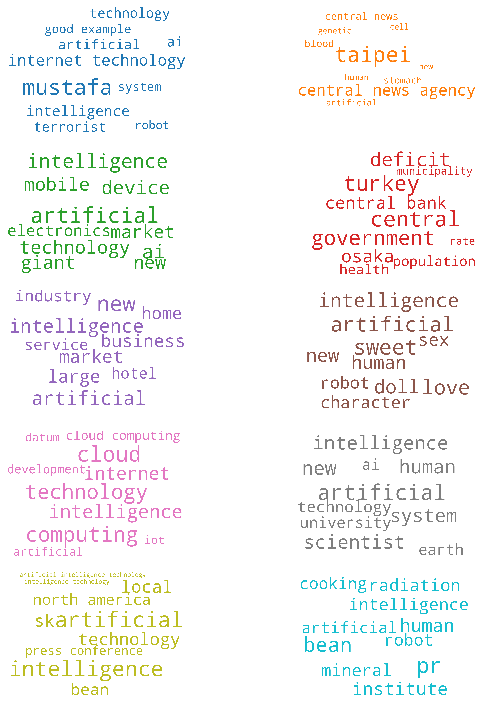

In [42]:
topics1 =topics[30:40]#does not plot more than 10, hence next ten , next ten iterate till no of topics
fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics1[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show();

Larger topics are more frequent in the corpus.
Topics closer together are more similar, topics further apart are less similar.
When you select a topic, you can see the most representative words for the selected topic. This measure can be a combination of how frequent or how discriminant the word is. You can adjust the weight of each property using the slider.
Hovering over a word will adjust the topic sizes according to how representative the word is for the topic.

In [24]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(LDModel, corpus, dictionary=LDModel.id2word)
vis

ModuleNotFoundError: No module named 'pyLDAvis'

# 5. What is the Dominant topic and its percentage contribution in each document

In [47]:
df4=pd.read_csv('jap2.csv', encoding='utf8')
'''
typically only one of the topics is dominant in one doc. The below code extracts this dominant topic for each doc and 
shows the weight of the topic and the keywords in a nicely formatted output.

What is the Dominant topic and its percentage contribution in each document
format documents to get a datafrme including: Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 
'content', 'title'. then transform this to a df df_dominant_topic including
'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'title'
in the end, we'll be able to see which topics are dominat in the doxuments, will get the docs w highest 
topic % contribution, hence will be able to read them in detail.

'''
 
'''5.1 get dominant topics per each doc'''

def format_topics_docs(ldamodel=LDModel, corpus=corpus, texts=lms, titles=df4.Title):
    # Init output
    doc_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    title = pd.Series(titles)
    doc_topics_df = pd.concat([doc_topics_df, contents, title], axis=1)
    return(doc_topics_df)

df_topic_docs_keywords = format_topics_docs(ldamodel=LDModel, corpus=corpus, texts=df4.Content, titles= df4.Title)

"5. What is the Dominant topic and its percentage contribution in each document\n\ntypically only one of the topics is dominant in one doc. The below code extracts this dominant topic for each doc and \nshows the weight of the topic and the keywords in a nicely formatted output.\n\nWhat is the Dominant topic and its percentage contribution in each document\nformat documents to get a datafrme including: Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', \n'content', 'title'. then transform this to a df df_dominant_topic including\n'Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'title'\nin the end, we'll be able to see which topics are dominat in the doxuments, will get the docs w highest \ntopic % contribution, hence will be able to read them in detail.\n\n       "

'5.1 get dominant topics per each doc'

In [48]:
# Format
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'title']

''' view texts  and dom tops for each doc'''
pd.set_option('display.max_colwidth', -1)
df_dominant_topic.loc[:5, ['Dominant_Topic', 'title']]

# Distribution of Dominant Topics in Each Document, no of docs with top i having as dom top 
dominant_topic_in_each_doc = df_dominant_topic.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()
# Distribution of Dominant Topics in Each Document, no of docs with top i having as dom top 

' view texts  and dom tops for each doc'

,Dominant_Topic,title
0,8.0,Will robots take your job? Quarter of US workers at risk
1,6.0,China bars millions from travel for 'social credit' offenses
2,1.0,How Google aims to simplify your life with AI
3,51.0,Google and Walmart team up to take on Amazon
4,10.0,Archbishop of Canterbury is accused of hypocrisy after slamming web giant Amazon for ‘leeching’ off taxpayers – as it emerges his Church holds a multi-million-pound stake in the retailer
5,21.0,"Robots could become CRIMINALS: Police may not be able to stop AI breaking the law, warn experts"


# 5.3 Distribution of Document Word Counts by Dominant Topic, is the topic in short or long docs?

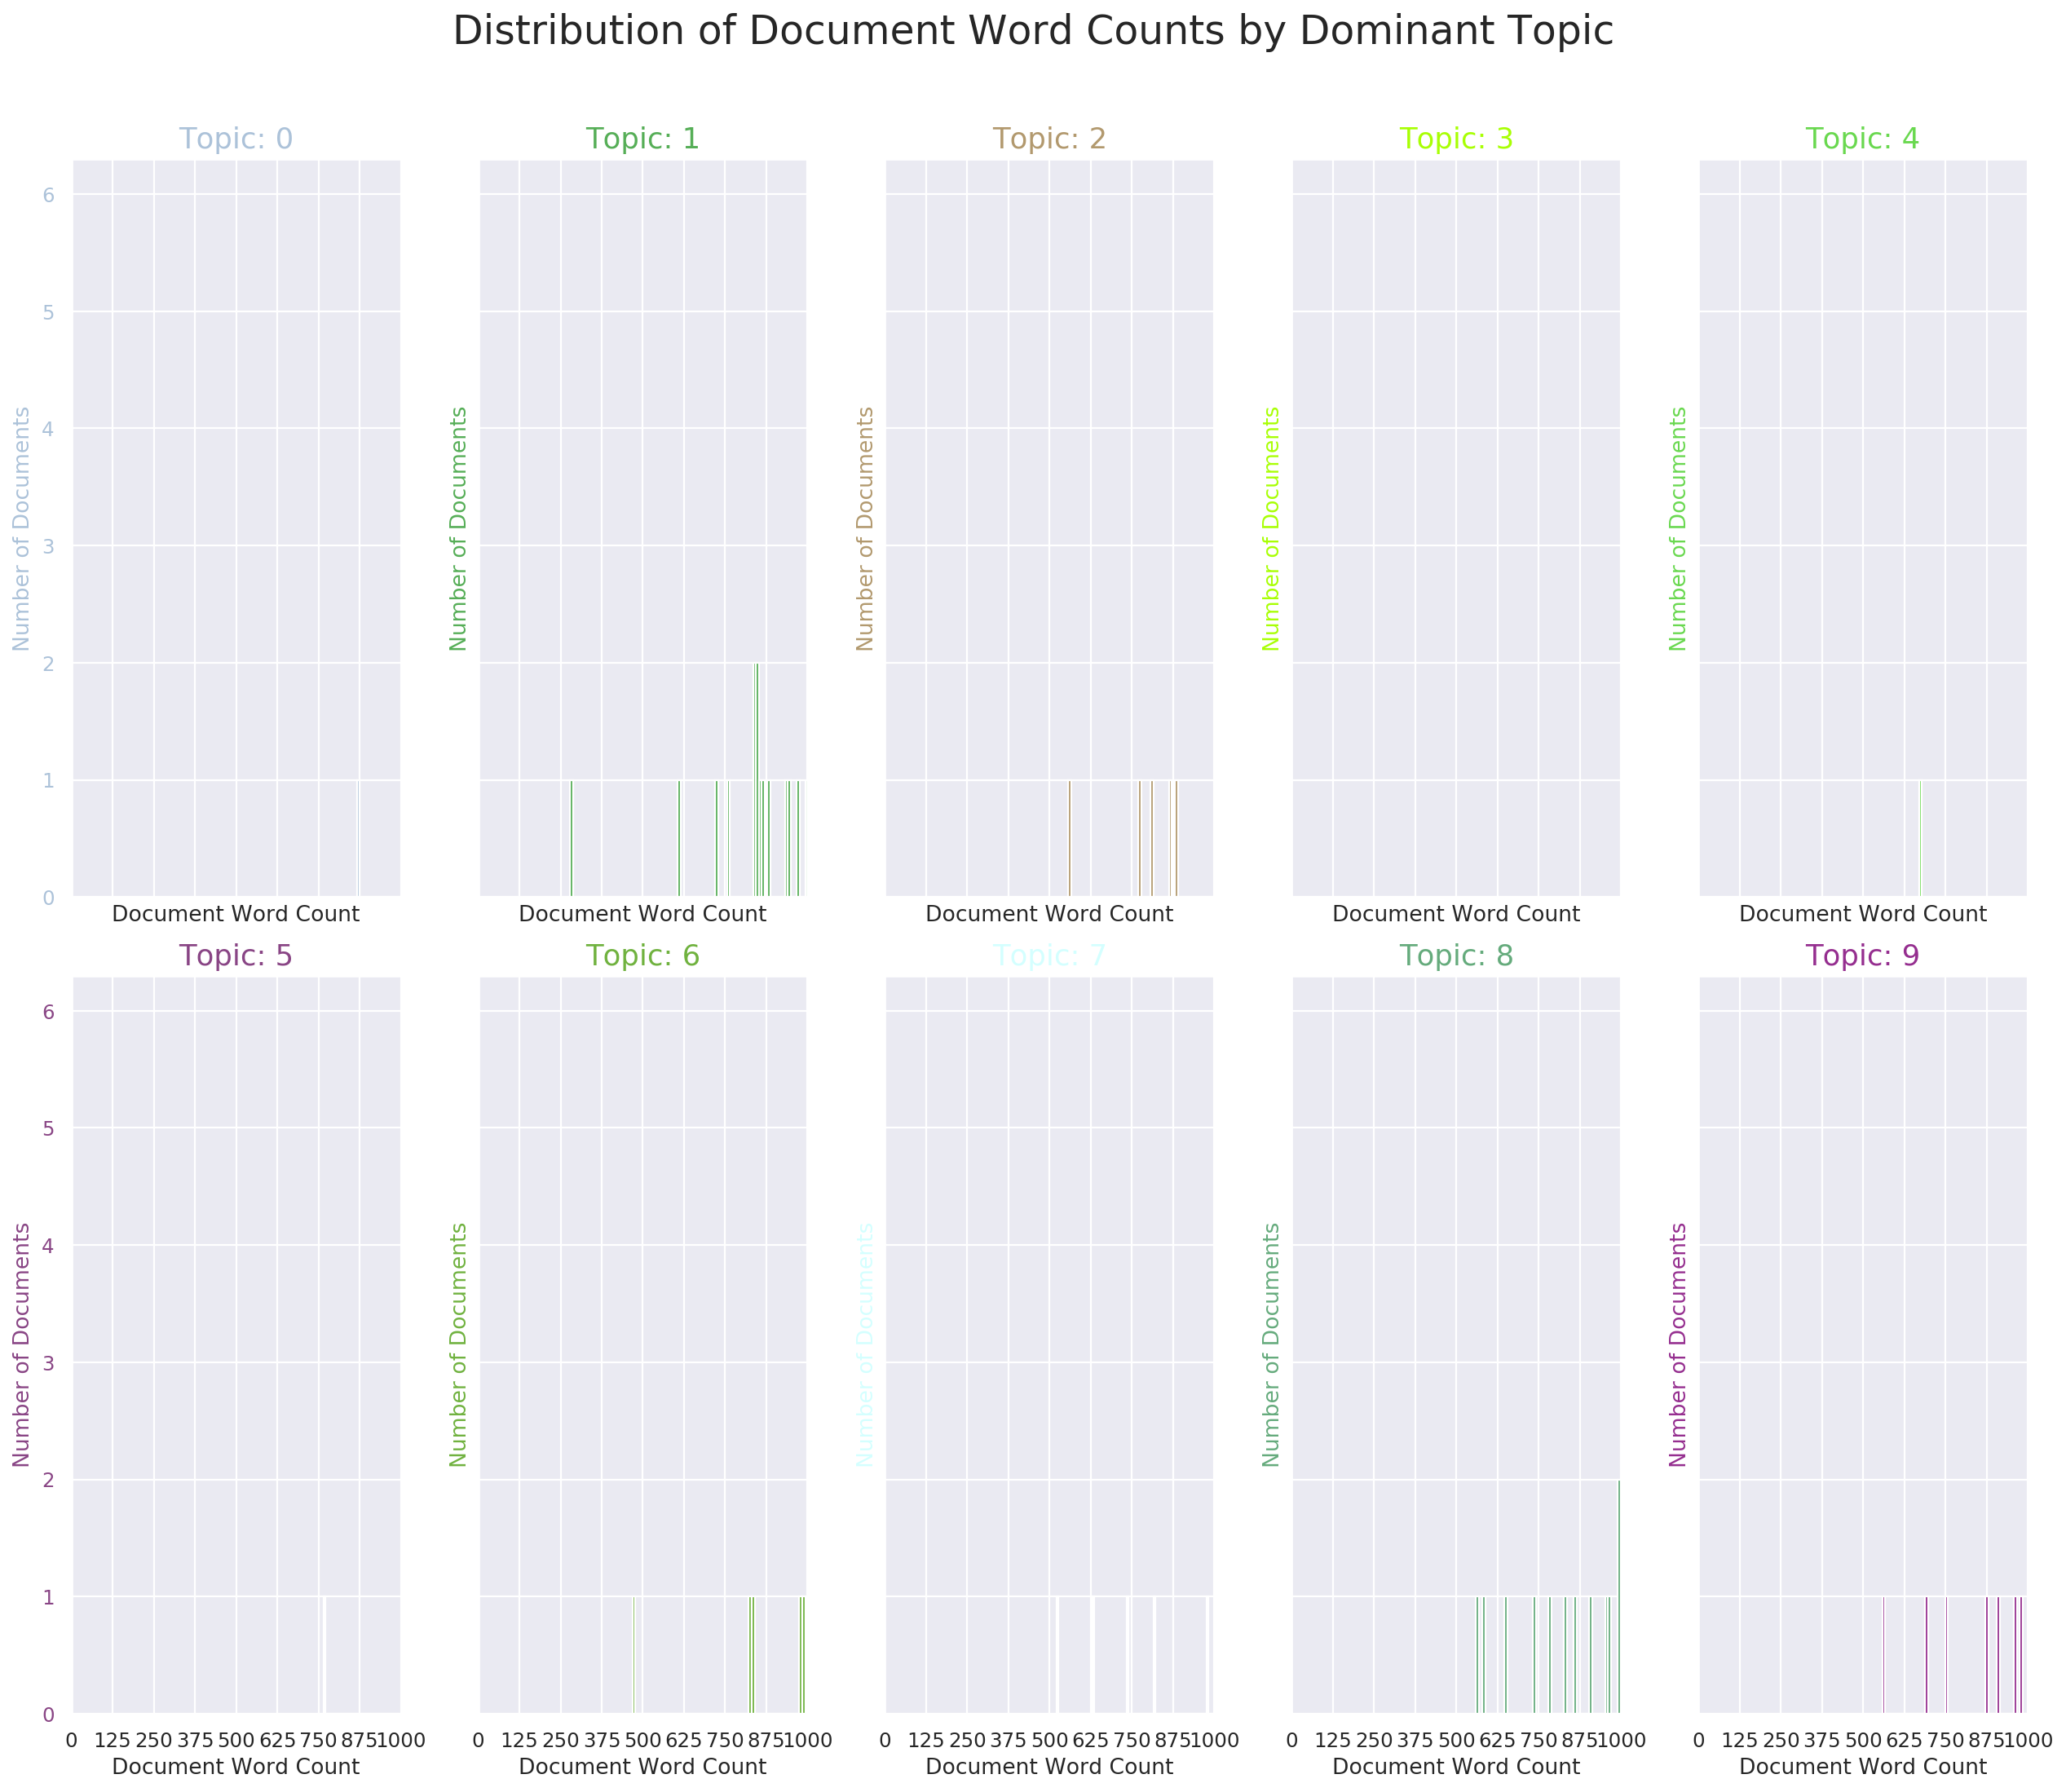

In [49]:
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
fig, axes = plt.subplots(2,5,figsize=(16,14), dpi=160, sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))
fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show();

# 5.4

What are the most discussed topics in the documents? distribution of no of docs to each topic?

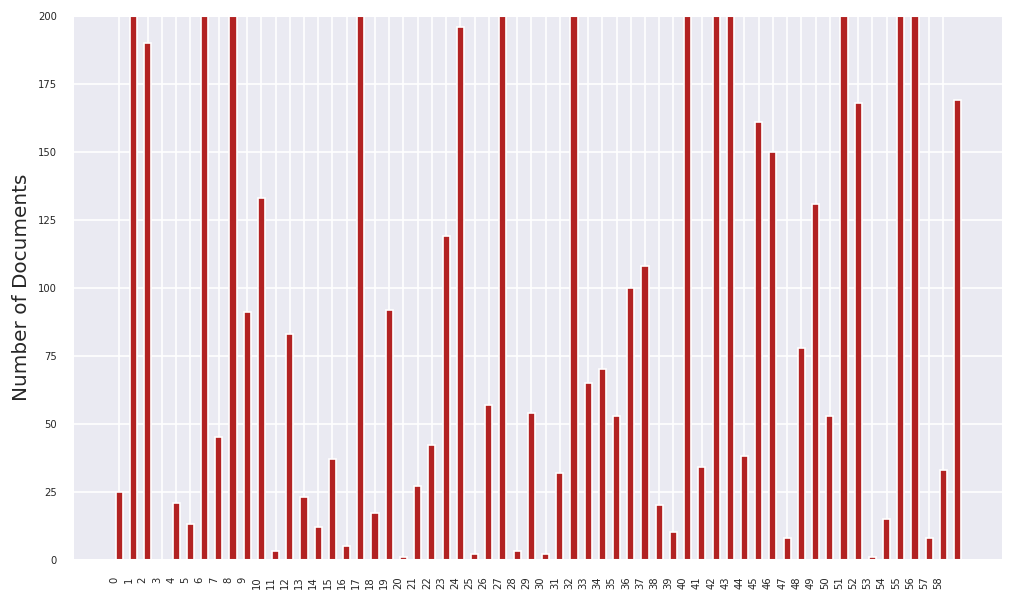

In [52]:
#Top 3 Keywords for each Topic, to see what the topics are abouut, as topi labels
topic_top3words = [(i, topic) for i, topics in LDModel.show_topics(formatted=False, num_topics=ntp) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg('.'.join)
df_top3words.reset_index(level=0,inplace=True)

fig, ax1 = plt.subplots(figsize=(10, 6), dpi=120)
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
#tick_formatter = ticker.FuncFormatter(lambda x, pos: df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
#ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 200)
ax1.tick_params(axis='both', which='major', labelsize=6, pad=4)
plt.xticks(rotation=90, ha='right')
plt.show();

In [53]:
df_top3words.reset_index(level=0,inplace=True)

In [54]:
df_top3words

,index,topic_id,words
0,0,0,income.job.yen
1,1,1,technology.artificial.new
2,2,2,disk.business.artificial
3,3,3,southeastern.artificial.intelligence
4,4,4,amazon web services.amazon web.amazon
5,5,5,financial group.artificial.intelligence
6,6,6,information.artificial.security
7,7,7,technology.artificial.business
8,8,8,artificial.technology.industry
9,9,9,artificial.intelligence.technology


# 5.5

Find the most representative 5 documents for each topic
you'll get: 'Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", 'title', hence will be able see the top docs

In [55]:
# Group top 5 docs under each topic
doc_topics_sorteddf_mallet = pd.DataFrame()

doc_topics_outdf_grpd = df_topic_docs_keywords.groupby('Dominant_Topic')

for i, grp in doc_topics_outdf_grpd:
    doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False)], 
                                            axis=0)
# Reset Index    
doc_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", 'title']


'5.5 Find the most representative 5 documents for each topic\nyou\'ll get: \'Topic_Num\', "Topic_Perc_Contrib", "Keywords", "Text", \'title\', hence will be able see the top docs\n'

In [56]:
tn=10#which topic docs you want to see?
cln ='Text' # title  "Keywords"   Text# what do you want to see?
hm = 5# how many docs do you want to see
slct = doc_topics_sorteddf_mallet.loc[doc_topics_sorteddf_mallet['Topic_Num'] == tn]

slct.loc[:, ["Topic_Perc_Contrib",cln]].head(hm)
x= slct.loc[:, ["Topic_Perc_Contrib",cln]].head(hm)

from gensim.summarization import summarize, keywords
for txt in x.Text:
    pprint(summarize(txt, ratio=.1))# word_count, ratio

Topic_Perc_Contrib  \
1951  0.9766               
1952  0.9323               
1953  0.8908               
1954  0.8599               
1955  0.8423               

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

('He joined SNL in 2003 and at 16 seasons and counting is the most_tenured '
 'cast member.')
('We ve long been told not to believe everything we read, but soon we ll have '
 'to question everything we see and hear as well.For now, there are several '
 'research teams working on capturing and synthesizing different visual and '
 'and audio elements of human behavior.Software developed at Stanford '
 'University is able to manipulate video footage of public figures to allow a '
 'second person to put words in their mouth in real time.\n'
 'The attacker can then talk into a microphone and the software will convert '
 'it so that the words sound like they are being spoken by the victim whether '
 'that s over the phone or on a radio show.Canadian startup Lyrebird has '
 'developed similar capabilities, which it says can be used to turn text into '
 'on_the_spot audiobooks read by famous voices or for characters in video '
 'games.Although their intentions may be well_meaning, voice_morphi

'5.5 11. doc Chart Colored by Topic \n1. Sentence Chart Colored by Topic\nEach word in the document is representative of one of the all topics. Let’s color each word in the given documents \nby the topic id it is attributed to. NEEDS SOME IMPROVEMT VIUSAILZATION\n\nhttps://markroxor.github.io/gensim/static/notebooks/topic_methods.html\n'

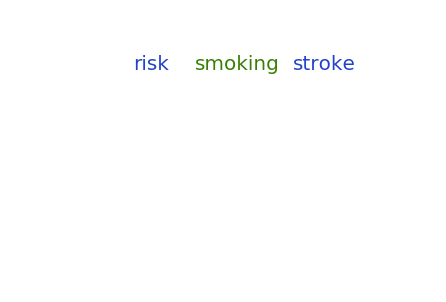

In [60]:
'''5.5 11. doc Chart Colored by Topic 
1. Sentence Chart Colored by Topic
Each word in the document is representative of one of the all topics. Let’s color each word in the given documents 
by the topic id it is attributed to. NEEDS SOME IMPROVEMT VIUSAILZATION

https://markroxor.github.io/gensim/static/notebooks/topic_methods.html
'''

def color_words(model, doc):
    # make into bag of words
    doc = model.id2word.doc2bow(doc)
    # get word_topics
    doc_topics, word_topics, phi_values = model.get_document_topics(doc, per_word_topics=True)
    # color-topic matching
    colormap = np.array([color for name, color in mcolors.XKCD_COLORS.items()])
    x =list(range(0,ntp))
    y= colormap[0:ntp]
    topic_colors = dict(zip(x,y))
    # set up fig to plot
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    # a sort of hack to make sure the words are well spaced out.
    word_pos = 1/len(doc)
    
    # use matplotlib to plot words
    for word, topics in word_topics:
        ax.text(word_pos, 0.8, model.id2word[word],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=20, color=topic_colors[topics[0]],  # choose just the most likely topic
                transform=ax.transAxes)
        word_pos += 0.2 # to move the word for the next iter

    ax.set_axis_off()
    plt.axis('off')
    plt.grid(b=None)
    plt.show()
    
text=df4.Title[257]
nl =spacy.load('en', disable=('vectors', 'textcat', "parser", "ner"))
doc = [w.lemma_ for w in nl(text) if not w.is_stop and  not w.is_punct and not w.like_num\
       and  w.text !='\n' ]
color_words(LDModel, doc)

In [ ]:
''' manual ;labeling of topics
top_labels = {0: 'Statistics', 1:'Numerical Analysis', 2:'Online Learning', 3:'Deep Learning'}
'''

In [64]:
'''TSNE PLOT
https://shuaiw.github.io/2016/12/22/topic-modeling-and-tsne-visualzation.html

'''

def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document. i.e. topic_weights, gives a doc by topic matrix
    """
    topic_weights = lda_model.get_document_topics(document, minimum_probability=0)
    topic_weights = np.array(topic_weights)
    return topic_weights[:,1]


arr  = list(map(lambda doc:
                          document_to_lda_features(LDModel, doc),
                          corpus))

'TSNE PLOT\nhttps://shuaiw.github.io/2016/12/22/topic-modeling-and-tsne-visualzation.html\n\n'

In [65]:
arr = pd.DataFrame(arr).fillna(0)# topic weights
# Keep the well separated points (optional)
doc_top_mat=arr.values

# Dominant topic number in each doc
_lda_keys = list(np.argmax(doc_top_mat, axis=1))#topic numbers
num_example = len(doc_top_mat)
topic_summaries= df_top3words['words'].values

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.5, init='pca')
# 35-D -> 2-D
tsne_lda = tsne_model.fit_transform(doc_top_mat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7621 samples in 0.014s...
[t-SNE] Computed neighbors for 7621 samples in 10.646s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7621
[t-SNE] Computed conditional probabilities for sample 2000 / 7621
[t-SNE] Computed conditional probabilities for sample 3000 / 7621
[t-SNE] Computed conditional probabilities for sample 4000 / 7621
[t-SNE] Computed conditional probabilities for sample 5000 / 7621
[t-SNE] Computed conditional probabilities for sample 6000 / 7621
[t-SNE] Computed conditional probabilities for sample 7000 / 7621
[t-SNE] Computed conditional probabilities for sample 7621 / 7621
[t-SNE] Mean sigma: 0.136123
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.947945
[t-SNE] KL divergence after 1000 iterations: 1.740942


In [66]:
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool

title = '35 LDA viz'
colormap = np.array([color for name, color in mcolors.XKCD_COLORS.items()])

plot_lda = bp.figure(plot_width=1400, plot_height=1100,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

    
plot_lda.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],
                 color=colormap[_lda_keys][:num_example],
              )

topic_coord = np.empty((np.array(doc_top_mat).shape[1], 2)) * np.nan
for topic_num in _lda_keys:
  if not np.isnan(topic_coord).any():
    break
  topic_coord[topic_num] = tsne_lda[_lda_keys.index(topic_num)]

# plot crucial words
for i in range(np.array(doc_top_mat).shape[1]):
  plot_lda.text(topic_coord[i, 0], topic_coord[i, 1], [topic_summaries[i]])

output_file("foo.html")
show(plot_lda)

GlyphRenderer(id='1028', ...)

GlyphRenderer(id='1035', ...)

GlyphRenderer(id='1042', ...)

GlyphRenderer(id='1049', ...)

GlyphRenderer(id='1056', ...)

GlyphRenderer(id='1063', ...)

GlyphRenderer(id='1070', ...)

GlyphRenderer(id='1077', ...)

GlyphRenderer(id='1084', ...)

GlyphRenderer(id='1091', ...)

GlyphRenderer(id='1098', ...)

GlyphRenderer(id='1105', ...)

GlyphRenderer(id='1112', ...)

GlyphRenderer(id='1119', ...)

GlyphRenderer(id='1126', ...)

GlyphRenderer(id='1133', ...)

GlyphRenderer(id='1140', ...)

GlyphRenderer(id='1147', ...)

GlyphRenderer(id='1154', ...)

GlyphRenderer(id='1161', ...)

GlyphRenderer(id='1168', ...)

GlyphRenderer(id='1175', ...)

GlyphRenderer(id='1182', ...)

GlyphRenderer(id='1189', ...)

GlyphRenderer(id='1196', ...)

GlyphRenderer(id='1203', ...)

GlyphRenderer(id='1210', ...)

GlyphRenderer(id='1217', ...)

GlyphRenderer(id='1224', ...)

GlyphRenderer(id='1231', ...)

GlyphRenderer(id='1238', ...)

GlyphRenderer(id='1245', ...)

GlyphRenderer(id='1252', ...)

GlyphRenderer(id='1259', ...)

GlyphRenderer(id='1266', ...)

GlyphRenderer(id='1273', ...)

GlyphRenderer(id='1280', ...)

GlyphRenderer(id='1287', ...)

GlyphRenderer(id='1294', ...)

GlyphRenderer(id='1301', ...)

GlyphRenderer(id='1308', ...)

GlyphRenderer(id='1315', ...)

GlyphRenderer(id='1322', ...)

GlyphRenderer(id='1329', ...)

GlyphRenderer(id='1336', ...)

GlyphRenderer(id='1343', ...)

GlyphRenderer(id='1350', ...)

GlyphRenderer(id='1357', ...)

GlyphRenderer(id='1364', ...)

GlyphRenderer(id='1371', ...)

GlyphRenderer(id='1378', ...)

GlyphRenderer(id='1385', ...)

GlyphRenderer(id='1392', ...)

GlyphRenderer(id='1399', ...)

GlyphRenderer(id='1406', ...)

GlyphRenderer(id='1413', ...)

GlyphRenderer(id='1420', ...)

GlyphRenderer(id='1427', ...)

GlyphRenderer(id='1434', ...)

GlyphRenderer(id='1441', ...)

GlyphRenderer(id='1448', ...)

ValueError: Out of range float values are not JSON compliant

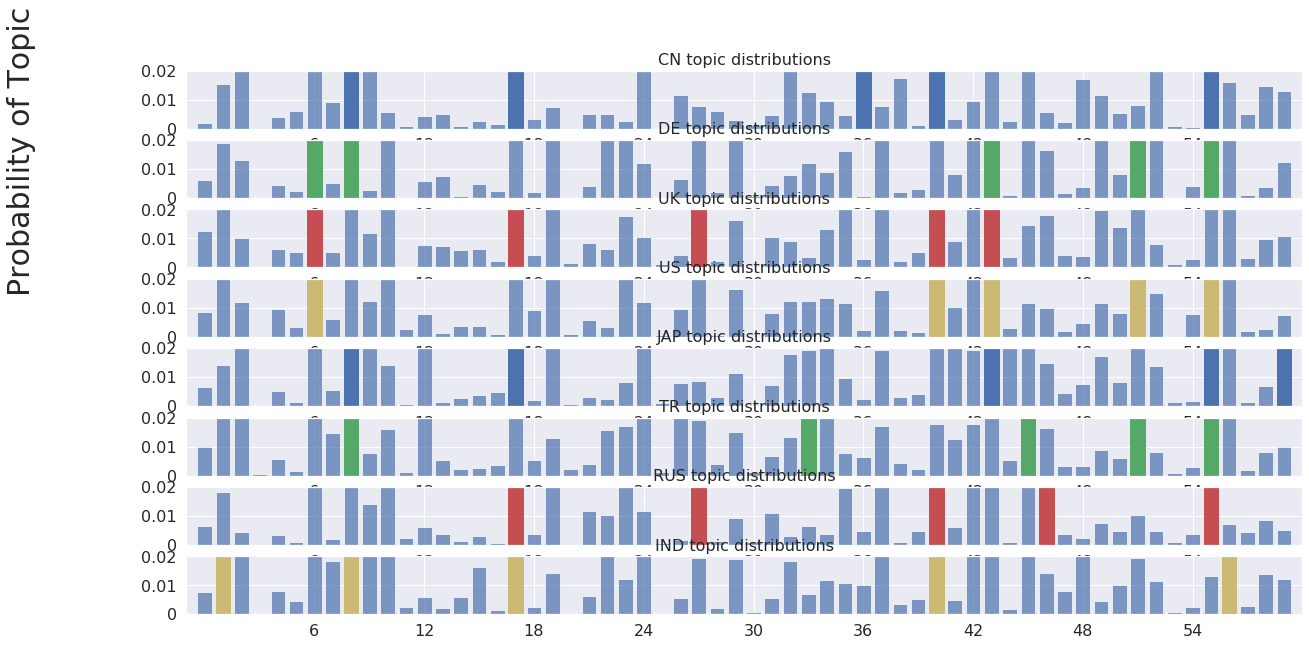

In [67]:
df4['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDModel, doc),
                                      corpus))
CN_topic_distribution = df4.loc[df4.country == 'cn', 'lda_features'].mean()
DE_topic_distribution = df4.loc[df4.country == 'ger', 'lda_features'].mean()
UK_topic_distribution = df4.loc[df4.country == 'uk', 'lda_features'].mean()
US_topic_distribution = df4.loc[df4.country == 'us', 'lda_features'].mean()
JAP_topic_distribution = df4.loc[df4.country == 'jap', 'lda_features'].mean()
TR_topic_distribution = df4.loc[df4.country == 'tr', 'lda_features'].mean()
RUS_topic_distribution = df4.loc[df4.country == 'rus', 'lda_features'].mean()
IND_topic_distribution = df4.loc[df4.country == 'ind', 'lda_features'].mean()

fig, [ax1,ax2,ax3, ax4, ax5, ax6, ax7, ax8] = plt.subplots(8,1,figsize=(20,10))

nr_top_bars = 5

ax1.set_title("CN topic distributions", fontsize=16)
ax2.set_title("DE topic distributions", fontsize=16)
ax3.set_title("UK topic distributions", fontsize=16)
ax4.set_title("US topic distributions", fontsize=16)
ax5.set_title("JAP topic distributions", fontsize=16)
ax6.set_title("TR topic distributions", fontsize=16)
ax7.set_title("RUS topic distributions", fontsize=16)
ax8.set_title("IND topic distributions", fontsize=16)

ax3.text(-10, 0.04, "Probability of Topic", fontsize=30, ha="center", va="center",
         rotation="vertical")

for ax, distribution, color in zip([ax1,ax2,ax3, ax4, ax5, ax6, ax7, ax8],
                                   [CN_topic_distribution,DE_topic_distribution,UK_topic_distribution, US_topic_distribution, JAP_topic_distribution,\
                                   TR_topic_distribution,RUS_topic_distribution,IND_topic_distribution],
                                   ['b','g','r', 'y','b','g','r', 'y']):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_color(color)
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, ntp)
    ax.set_xticks(range(int(ntp/10),ntp,int(ntp/10)))
    ax.set_xticklabels(range(int(ntp/10),ntp,int(ntp/10)), fontsize=16)
    ax.set_ylim(0,0.02)
    ax.set_yticks([0,0.01,0.02])
    ax.set_yticklabels([0,0.01,0.02], fontsize=16)

fig.tight_layout(h_pad=3.);

In [69]:
'''topic words per count'''
def get_topic_top_words(lda_model, topic_id, nr_top_words=10):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words


for country, distribution in zip(['CN', 'DE', 'UK', 'US','JAP', 'TR', 'RUS', 'IND'], [CN_topic_distribution,DE_topic_distribution,UK_topic_distribution, US_topic_distribution, JAP_topic_distribution,\
                                   TR_topic_distribution,RUS_topic_distribution,IND_topic_distribution]):
    print("Looking up top words from top topics from {}.".format(country))
    for x in sorted(np.argsort(distribution)[-10:]):
        top_words = get_topic_top_words(LDModel, x)
        print("For topic {}, : {}.".format(x, ", ".join(top_words)))
    print("")

'topic words per count'

Looking up top words from top topics from CN.
For topic 2, : disk, business, artificial, industry, intelligence, technology, market, global, financial, datum.
For topic 8, : artificial, technology, industry, intelligence, sector, development, economic, government, new, economy.
For topic 17, : artificial, intelligence, technology, ai, machine, system, human, new, learning, development.
For topic 24, : artificial, intelligence, technology, industrial, fourth, new, business, development, government, revolution.
For topic 32, : artificial, intelligence, ai, device, technology, giant, mobile, new, market, electronics.
For topic 36, : cloud, computing, technology, intelligence, internet, cloud computing, development, artificial, datum, iot.
For topic 40, : intelligence, artificial, system, human, technology, ai, new, machine, datum, large.
For topic 45, : minister, intelligence, artificial, prime minister, technology, development, government, prime, new, issue.
For topic 52, : artificial, i